## Проект ЯндексПрактикум - мастерская 2

### Подбор приближенных соседей при помощи библиотеки faiss

#### Описание проекта



Заказчиком исследования является крупная торговая площадка, целью исследования является поиск ближайших соседей для товаров с целью предложения релевантных. Каждый товар представлен вектором с размерностью 72.

Наша цель используя приближенный поиск соседей с высокой долей вероятности предлагать релевантный товар

#### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import faiss
import random
from sklearn.preprocessing import RobustScaler
import time 
from tqdm.notebook import tqdm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, mean_squared_error

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline

#### Переменные и констатнты

In [4]:
k = 50
n_cells = 100
scaler = RobustScaler()

#### Загрузка датасетов, мы будем использовать faiss - ему нужно float32 - соответственно загружаем с помощью словаря

In [5]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'
dict_answer = dict_base.copy()
dict_answer['Expected'] = 'str'

In [6]:
df_base = pd.read_csv('C:\data/base.csv', index_col=0, dtype=dict_base)
#df_base.head()

In [7]:
df_train = pd.read_csv('C:\data/train.csv', index_col=0, dtype=dict_train)
#df_train.head()

In [8]:
df_valid = pd.read_csv('C:\data/validation.csv', index_col=0, dtype=dict_base)
#df_valid.head()

In [9]:
df_answer = pd.read_csv('C:\data/validation_answer.csv', index_col=0, dtype=dict_answer)
df_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


#### Посмотрим как распределены данные

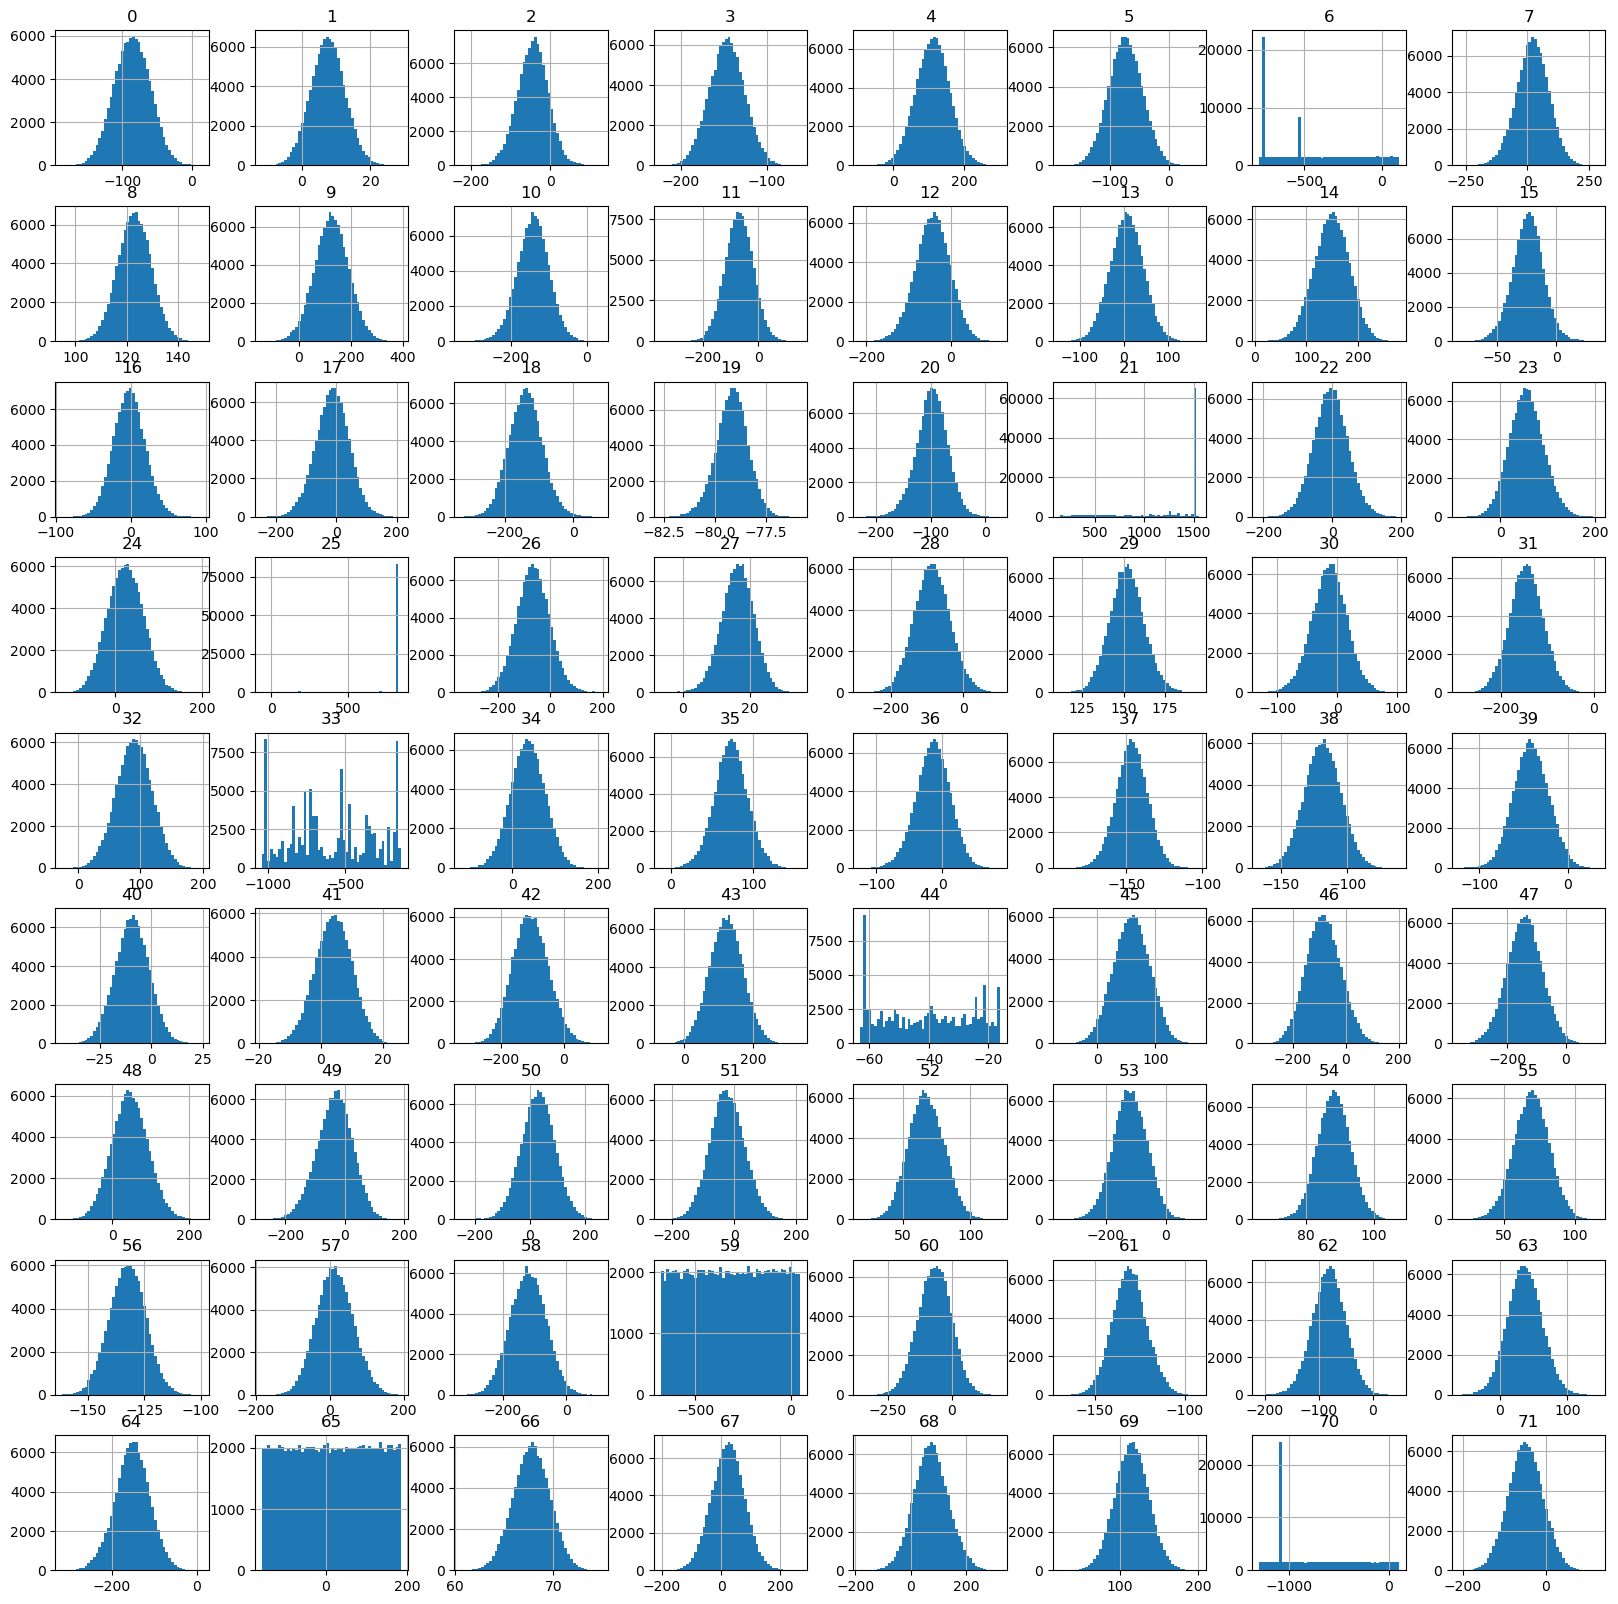

In [10]:
df_train.hist(figsize=[20, 20], bins=50);

#### Уберем лишние колонки с ненормальным распределением, колонки 6, 21, 25, 44 и 70

In [11]:
cols_to_drop = ['70', '65', '44', '25', '21', '6']

In [12]:
df_base.drop(columns=cols_to_drop, axis=1, inplace=True)

In [13]:
df_valid.drop(columns=cols_to_drop, axis=1, inplace=True)

In [14]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [68]:
targets_valid = df_answer["Expected"]


In [16]:
df_train.drop(columns=cols_to_drop, axis=1, inplace=True)

Посмотрим что у нас все удалилось

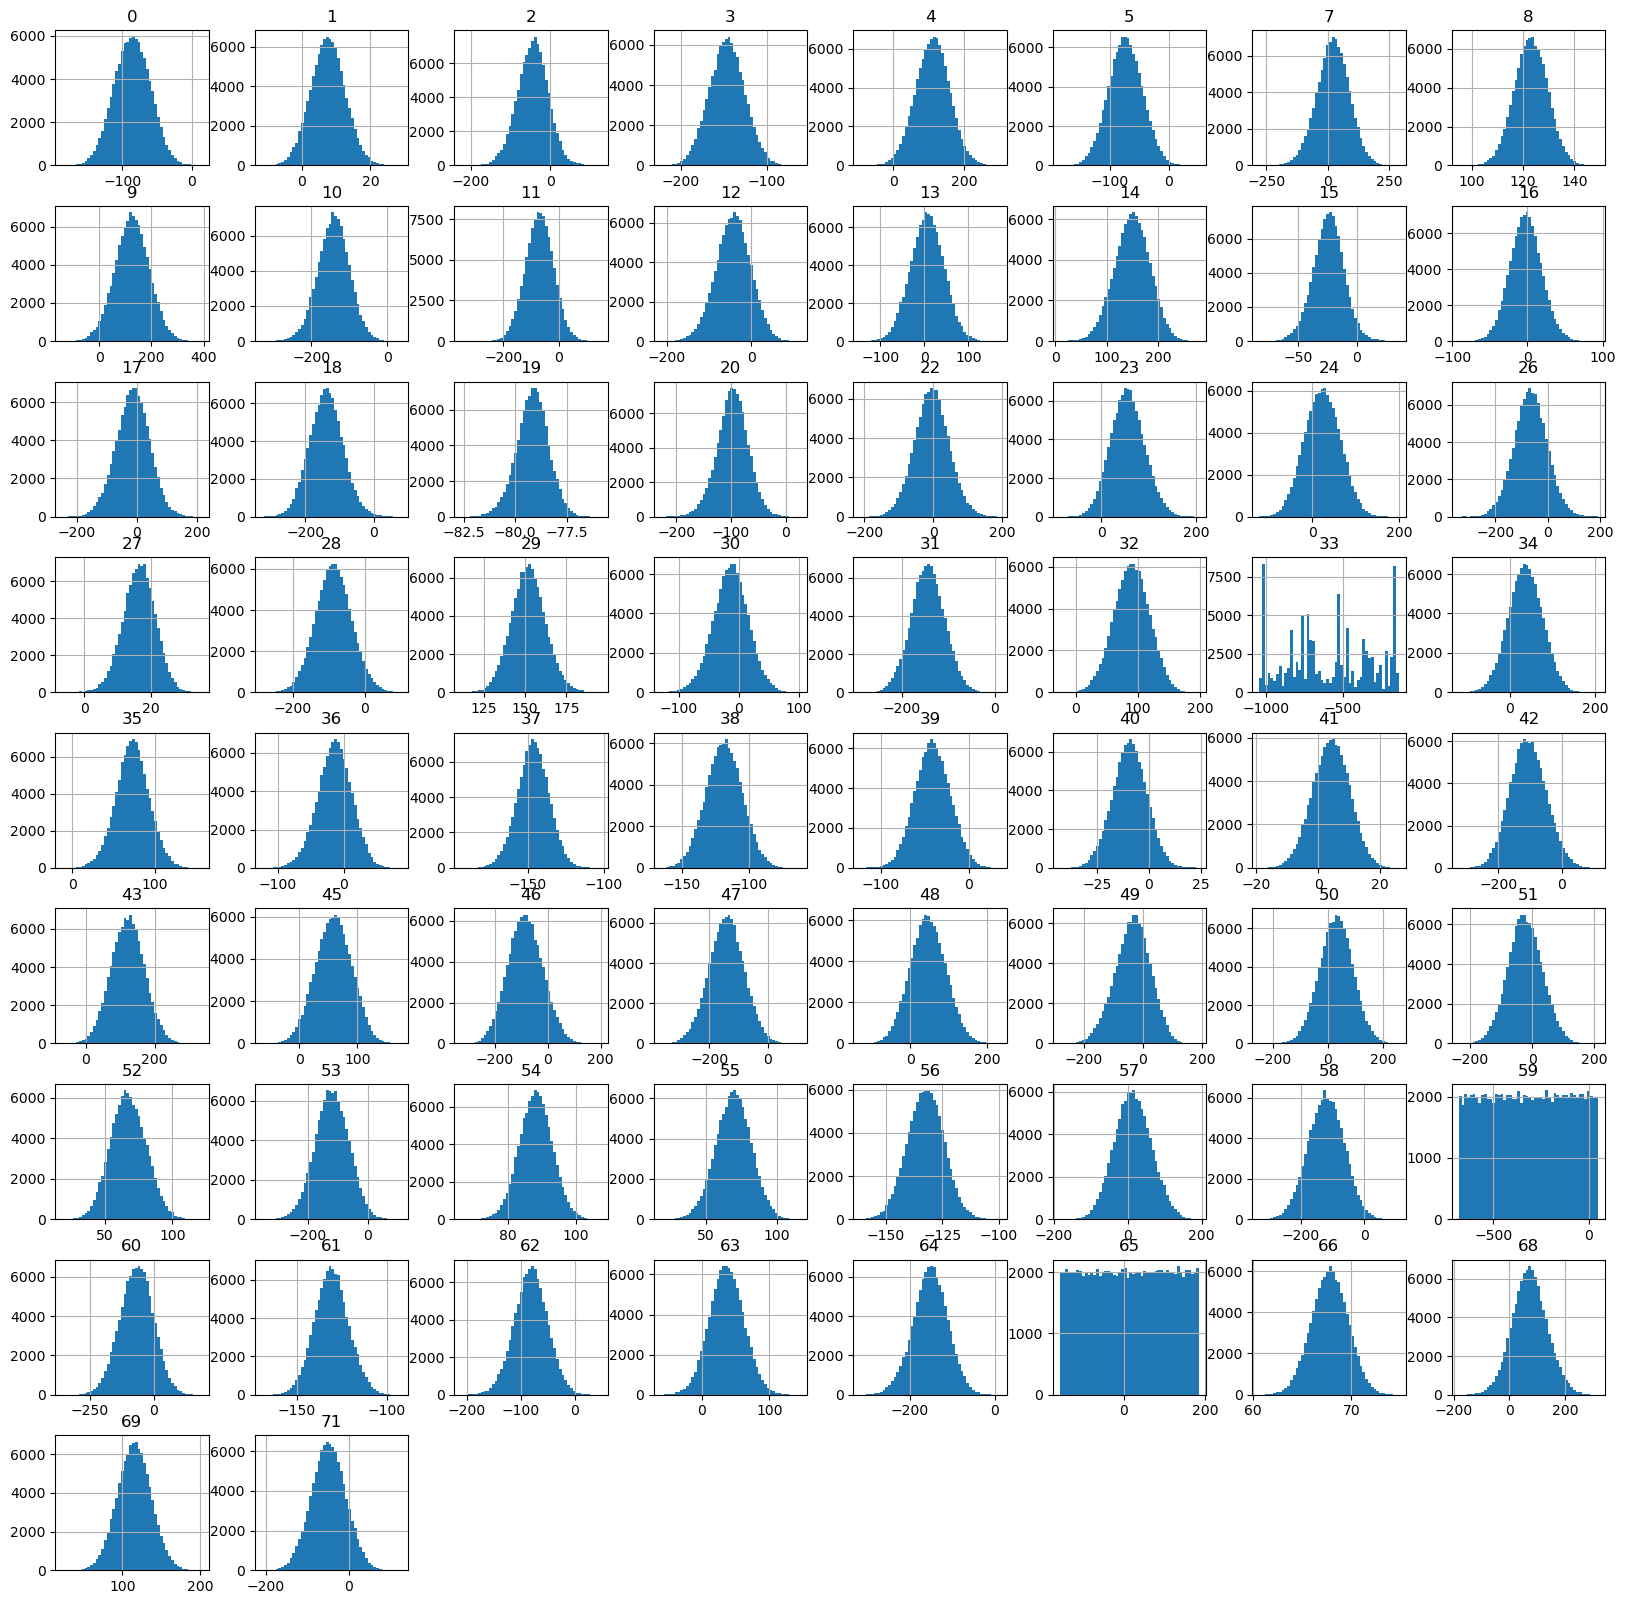

In [17]:
df_train.hist(figsize=[20, 20], bins=50);

#### Создадим словарь для быстрого поиска индексов по номеру запроса

In [18]:
df_base.index

Index(['0-base', '1-base', '2-base', '3-base', '4-base', '5-base', '6-base',
       '7-base', '8-base', '9-base',
       ...
       '4744747-base', '4744748-base', '4744749-base', '4744753-base',
       '4744754-base', '4744755-base', '4744759-base', '4744762-base',
       '4744763-base', '4744766-base'],
      dtype='object', name='Id', length=2918139)

In [19]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [20]:
print(base_index[1])

1-base


#### Произведем масштабирование признаков

Я сохраню отмасштабированные датасеты в отдельные, так как мне предстоит еще обучить ранжирующую модель, хочу иметь данные в исходном виде для этого

In [21]:
df_base2 = scaler.fit_transform(df_base)
df_train2 = scaler.transform(df_train)



In [22]:
df_valid2 = scaler.transform(df_valid)

In [23]:
df_valid2.shape

(100000, 66)

In [24]:
df_base2.shape

(2918139, 66)

In [25]:
df_train2.shape

(100000, 66)

#### Создание индекса FAISS

Чем больше n_cells (количество центроидов для кластеров) - Тем быстрее осуществляется поиск ближайших соседей, так как 
В данном исследовании мы проверим 1)какую точность в поиске соседей может нам дать faiss, измерим время поиска
Также попробуем сократить время поиска или улучшить accuracy взяв крупное количество кластеров и применив отдельно обученную ранжирующую модель

начнем с малого количества центроидов чтобы оценить время поиска и время создания индекса, в будущем я хочу понять, сколько времени сэкономит ранжирующая модель

In [26]:
dims = df_base2.shape[1]
n_cells = 10
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [27]:
## измерим время выполнения кода 
start = time.time() 
idx_l2.train(np.ascontiguousarray(df_base2[:250000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))
end = time.time() - start 
print(f' time s = {round(end)}')

 time s = 2


In [28]:
## Измерим время работы поиска
start = time.time() 

k=5
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f' accuracy = {100 * acc / len(idx)}')

end = time.time() - start 
print(f' time s = {round(end)}')

 accuracy = 59.918
 time s = 301


Хорошая accuracy, но очень долгое время выполнения кода.
Теперь попробуем сильно увеличить n_cells, я предположу что время выполнения кода сильно снизится, но наряду с этим упадет и точность

In [29]:
dims = df_base2.shape[1]
n_cells = 2000
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)


In [30]:
## также, измерим время выполнения кода 
start = time.time() 
idx_l2.train(np.ascontiguousarray(df_base2[:250000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))
end = time.time() - start 
print(f' time s = {round(end)}')

 time s = 417


Достаточно долго обучается индекс

In [31]:
## также, измерим время выполнения кода 
start = time.time() 

k=5
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f' accuracy = {100 * acc / len(idx)}')

end = time.time() - start 
print(f' time s = {round(end)}')

 accuracy = 57.824
 time s = 3


Уже неплохо: за 3 секунды он нашел 5 соседей с аккураси5 57.9%

In [32]:
dims = df_base2.shape[1]
n_cells = 150
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [33]:
## также, измерим время выполнения кода 
start = time.time() 
idx_l2.train(np.ascontiguousarray(df_base2[:250000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))
end = time.time() - start 
print(f' time s = {round(end)}')

 time s = 20


In [34]:
## также, измерим время выполнения кода 
start = time.time() 

k=5
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f' accuracy = {100 * acc / len(idx)}')

end = time.time() - start 
print(f' time s = {round(end)}')

 accuracy = 60.26
 time s = 23


In [35]:
## также, измерим время выполнения кода 
start = time.time() 

k=70
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f' accuracy = {100 * acc / len(idx)}')

end = time.time() - start 
print(f' time s = {round(end)}')

 accuracy = 66.536
 time s = 24


Я нашел более-менее оптимальные параметры для индекса faiss: 70 соседей с точностью 66.5 за 24 секунд для 100000 запросов!

Теперь с помощью модели машинного обучения попробуем выбрать по 5 для каждого, и посчитаем время

In [36]:
nbrs = idx.tolist()

Получили список списков с ответами, далее преобразуем его в датафрейм, который впоследтсвии скормим модели машинного обучения

In [37]:
print(nbrs[1])

[15185, 737853, 902634, 464427, 311357, 2584784, 2469267, 1540755, 124343, 1252594, 1325497, 295462, 1007827, 2151558, 51220, 176701, 1012984, 2733705, 1149318, 2709823, 1238630, 395014, 1627647, 2747244, 838522, 781791, 370540, 1494616, 1672464, 904384, 1989833, 2419689, 1854808, 193752, 690454, 857560, 2668355, 722763, 1393708, 2604152, 357613, 1592384, 1146066, 2058066, 1026561, 2782675, 1503950, 1230304, 2553914, 1022275, 476987, 1252285, 413070, 2843018, 1415723, 2070954, 2694334, 180047, 2186413, 485998, 1405553, 1917802, 1207556, 372055, 2700717, 704508, 2202245, 217284, 2162616, 1694178]


In [38]:
filter_list = []
for i in nbrs[1]:
    filter_list.append(base_index[i])

In [42]:
filter_list[:5]

['15226-base', '854272-base', '1075687-base', '511045-base', '332510-base']

### Обучение модели ранжирования

Сначала сделаем обучающий датасет - склеим признаки из df_train и соответствующие им в base, получим датасет на 135 колонокб сделаем новый таргет - он у нас будет 1, далее сделаем еще пару таких датасетовб в которых случайно перемешаем признаки и сделаем там таргет 0 Далее я склею датасеты и получу один на 300000 строк в которых 100000 - единицы и 200000 - нули мне должно этого хватить для обучения модели

In [43]:
df_base_model = pd.DataFrame(data=df_base2, index=df_base.index)
df_base_model['target'] = df_base_model.index

In [44]:
df_train_model = pd.DataFrame(data=df_train2, index=df_train.index)
df_train_model['target'] = targets

In [45]:
#склеим признаки из тренировочного и базового датасетов
df_model = df_train_model.join(df_base_model, on='target', how='left', rsuffix='_1')
df_model.drop(['target_1', 'target'], axis=1, inplace=True)
df_model['target_new'] = 1
df_model.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,17_1,18_1,19_1,20_1,21_1,22_1,23_1,24_1,25_1,26_1,27_1,28_1,29_1,30_1,31_1,32_1,33_1,34_1,35_1,36_1,37_1,38_1,39_1,40_1,41_1,42_1,43_1,44_1,45_1,46_1,47_1,48_1,49_1,50_1,51_1,52_1,53_1,54_1,55_1,56_1,57_1,58_1,59_1,60_1,61_1,62_1,63_1,64_1,65_1,target_new
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,0.956813,1.468961,0.034035,-1.398175,1.222708,-0.390937,0.203191,-1.744734,-1.089301,0.969303,0.256548,0.245314,-0.065616,1.061417,-0.411190,-0.097123,-1.609982,-0.416952,0.666825,0.082436,-0.904177,0.461992,1.540006,-0.104453,-0.612818,-1.517187,-0.144048,-0.406028,0.239372,0.518481,0.524675,0.250544,-0.587288,1.147156,-0.338639,0.805251,0.291133,-0.284302,-0.177611,-0.101753,0.469893,0.520106,-0.360552,-1.384782,-0.665416,-1.327706,0.526034,-0.240117,-0.245892,-0.203481,...,-1.106994,-0.075396,0.240682,-0.937226,0.344460,1.795769,-0.324990,-0.396894,-1.617934,-0.106570,-0.437229,-0.276430,0.542517,0.868527,-0.135474,-1.084891,0.913965,-0.249466,0.283722,0.408330,-0.668990,-0.130911,-0.210944,0.132396,0.669718,-0.285559,-0.954194,-0.424014,-1.513123,-0.479957,0.009562,0.427865,-0.305721,-0.554402,0.444144,0.688407,-0.163675,-1.301279,0.878228,-0.048406,-0.415762,-0.715156,1.296441,0.040938,0.249298,-0.379632,-0.424276,0.034364,0.543249,1
1-query,-0.045694,-0.182307,0.235551,-1.146973,0.144349,-0.305307,-1.152057,0.120621,0.196990,-0.648642,-0.216103,1.606632,-1.317846,-1.136937,0.209403,0.062125,0.977375,-0.307467,0.519355,0.126784,-0.401932,0.549698,-1.058037,-0.866993,1.651740,-0.791085,0.127971,1.536517,0.618768,0.015824,0.714780,-0.190563,0.618074,-0.404945,0.760211,-1.232253,-0.055069,0.204332,0.524599,-0.062485,0.456763,0.809698,0.293715,0.700183,-0.156950,0.075719,0.594313,0.218166,0.495464,0.075587,...,0.091658,1.034768,-0.218530,0.300677,1.938907,-0.969519,-1.227524,-0.287878,0.589899,0.550435,0.356159,-2.098316,0.795473,0.868527,0.012330,-0.048976,-0.700372,-0.159772,-0.963024,-1.018932,0.903216,-0.269135,-1.112238,-0.378796,1.330930,1.320582,0.530834,-0.069289,-0.142513,0.590774,0.052672,-0.076260,0.975288,0.604196,0.100607,0.161261,-1.438674,0.033392,0.328194,0.868074,-0.096571,0.033019,-0.633679,-0.164072,0.421331,1.003850,-0.320190,-0.534724,-0.412376,1
2-query,1.072261,-0.620782,-1.447945,-1.265179,1.264912,0.541482,-0.594990,0.221400,1.031093,1.000680,0.505736,1.096586,-1.792432,-0.246904,-0.035723,-1.620266,0.043779,-0.960924,0.806279,0.750123,-0.653884,-1.966108,0.491637,0.585531,0.737750,0.543568,0.531487,0.291073,-0.854653,0.323131,-1.138900,-1.627965,0.828364,0.154134,0.172142,-0.856421,-1.425373,-0.704852,0.051931,0.631037,0.542479,-0.232488,-0.437746,0.322470,0.107146,-0.025040,1.025550,0.560032,0.614315,0.298014,...,-0.989258,-0.030730,0.508365,-0.237334,-1.498566,0.349340,0.075438,0.534689,1.256927,0.013738,0.391053,-1.039939,0.198883,0.368941,-1.205013,0.443664,-0.212479,0.199629,-0.954940,-1.638589,0.065891,-0.097996,0.285369,0.346346,-0.584623,-0.209858,0.153524,-0.009812,0.548806,1.304116,0.147306,0.132059,0.021558,-0.133633,-0.530240,0.207289,0.136922,-0.963040,-0.063993,-0.574965,-1.100459,0.679487,1.703616,-0.418114,0.620905,-0.632790,1.165128,0.546807,0.278307,1
3-query,1.136416,0.154941,-1.433588,0.969449,-0.278345,-0.958763,0.677757,0.013062,1.394367,-0.086777,-1.305897,0.512693,-0.287059,-0.657531,-1.243944,0.371283,0.475203,-0.334776,0.389276,0.499782,0.374251,-0.478011,-0.684371,-0.722081,0.192543,0.418053,-0.773967,-1.120970,0.156507,-0.609528,-1.138900,1.007280,-0.310665,-0.219493,-0.422005,1.541254,0.533381,0.428541,-0.484318,-0.206643,0.047716,1.440249,0.558445,0.852883,0.400391,-1.790596,1.158251,0.060054,-1.718956,-0.271680,...,-0.019096,0.552271,0.531414,0.735994,-0.731263,-0.397852,-0.322480,-0.012335,0.341283,-0.462266,-0.880859,0.013184,-0.320745,0.111074,0.814795,0.133118,-0

In [46]:
targets2 = targets.copy()

In [47]:
targets3 = targets.copy()

In [48]:
random.shuffle(targets2)
random.shuffle(targets3)

In [49]:
df_base_model2 = pd.DataFrame(data=df_base2, index=df_base.index)
df_base_model2['target'] = df_base_model.index
df_train_model2 = pd.DataFrame(data=df_train2, index=df_train.index)
df_train_model2['target'] = targets2
df_model2 = df_train_model2.join(df_base_model2, on='target', how='left', rsuffix='_1')
df_model2.drop(['target_1', 'target'], axis=1, inplace=True)
df_model2['target_new'] = 0
#df_model2.head()

In [50]:
df_base_model3 = pd.DataFrame(data=df_base2, index=df_base.index)
df_base_model3['target'] = df_base_model.index
df_train_model3 = pd.DataFrame(data=df_train2, index=df_train.index)
df_train_model3['target'] = targets3
df_model3 = df_train_model2.join(df_base_model2, on='target', how='left', rsuffix='_1')
df_model3.drop(['target_1', 'target'], axis=1, inplace=True)
df_model3['target_new'] = 0
#df_model3.head()

In [51]:
df_model_final = pd.concat([df_model, df_model2, df_model3], ignore_index=True) 

In [52]:
df_model_final.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,17_1,18_1,19_1,20_1,21_1,22_1,23_1,24_1,25_1,26_1,27_1,28_1,29_1,30_1,31_1,32_1,33_1,34_1,35_1,36_1,37_1,38_1,39_1,40_1,41_1,42_1,43_1,44_1,45_1,46_1,47_1,48_1,49_1,50_1,51_1,52_1,53_1,54_1,55_1,56_1,57_1,58_1,59_1,60_1,61_1,62_1,63_1,64_1,65_1,target_new
0,0.956813,1.468961,0.034035,-1.398175,1.222708,-0.390937,0.203191,-1.744734,-1.089301,0.969303,0.256548,0.245314,-0.065616,1.061417,-0.411190,-0.097123,-1.609982,-0.416952,0.666825,0.082436,-0.904177,0.461992,1.540006,-0.104453,-0.612818,-1.517187,-0.144048,-0.406028,0.239372,0.518481,0.524675,0.250544,-0.587288,1.147156,-0.338639,0.805251,0.291133,-0.284302,-0.177611,-0.101753,0.469893,0.520106,-0.360552,-1.384782,-0.665416,-1.327706,0.526034,-0.240117,-0.245892,-0.203481,...,-1.106994,-0.075396,0.240682,-0.937226,0.344460,1.795769,-0.324990,-0.396894,-1.617934,-0.106570,-0.437229,-0.276430,0.542517,0.868527,-0.135474,-1.084891,0.913965,-0.249466,0.283722,0.408330,-0.668990,-0.130911,-0.210944,0.132396,0.669718,-0.285559,-0.954194,-0.424014,-1.513123,-0.479957,0.009562,0.427865,-0.305721,-0.554402,0.444144,0.688407,-0.163675,-1.301279,0.878228,-0.048406,-0.415762,-0.715156,1.296441,0.040938,0.249298,-0.379632,-0.424276,0.034364,0.543249,1
1,-0.045694,-0.182307,0.235551,-1.146973,0.144349,-0.305307,-1.152057,0.120621,0.196990,-0.648642,-0.216103,1.606632,-1.317846,-1.136937,0.209403,0.062125,0.977375,-0.307467,0.519355,0.126784,-0.401932,0.549698,-1.058037,-0.866993,1.651740,-0.791085,0.127971,1.536517,0.618768,0.015824,0.714780,-0.190563,0.618074,-0.404945,0.760211,-1.232253,-0.055069,0.204332,0.524599,-0.062485,0.456763,0.809698,0.293715,0.700183,-0.156950,0.075719,0.594313,0.218166,0.495464,0.075587,...,0.091658,1.034768,-0.218530,0.300677,1.938907,-0.969519,-1.227524,-0.287878,0.589899,0.550435,0.356159,-2.098316,0.795473,0.868527,0.012330,-0.048976,-0.700372,-0.159772,-0.963024,-1.018932,0.903216,-0.269135,-1.112238,-0.378796,1.330930,1.320582,0.530834,-0.069289,-0.142513,0.590774,0.052672,-0.076260,0.975288,0.604196,0.100607,0.161261,-1.438674,0.033392,0.328194,0.868074,-0.096571,0.033019,-0.633679,-0.164072,0.421331,1.003850,-0.320190,-0.534724,-0.412376,1
2,1.072261,-0.620782,-1.447945,-1.265179,1.264912,0.541482,-0.594990,0.221400,1.031093,1.000680,0.505736,1.096586,-1.792432,-0.246904,-0.035723,-1.620266,0.043779,-0.960924,0.806279,0.750123,-0.653884,-1.966108,0.491637,0.585531,0.737750,0.543568,0.531487,0.291073,-0.854653,0.323131,-1.138900,-1.627965,0.828364,0.154134,0.172142,-0.856421,-1.425373,-0.704852,0.051931,0.631037,0.542479,-0.232488,-0.437746,0.322470,0.107146,-0.025040,1.025550,0.560032,0.614315,0.298014,...,-0.989258,-0.030730,0.508365,-0.237334,-1.498566,0.349340,0.075438,0.534689,1.256927,0.013738,0.391053,-1.039939,0.198883,0.368941,-1.205013,0.443664,-0.212479,0.199629,-0.954940,-1.638589,0.065891,-0.097996,0.285369,0.346346,-0.584623,-0.209858,0.153524,-0.009812,0.548806,1.304116,0.147306,0.132059,0.021558,-0.133633,-0.530240,0.207289,0.136922,-0.963040,-0.063993,-0.574965,-1.100459,0.679487,1.703616,-0.418114,0.620905,-0.632790,1.165128,0.546807,0.278307,1
3,1.136416,0.154941,-1.433588,0.969449,-0.278345,-0.958763,0.677757,0.013062,1.394367,-0.086777,-1.305897,0.512693,-0.287059,-0.657531,-1.243944,0.371283,0.475203,-0.334776,0.389276,0.499782,0.374251,-0.478011,-0.684371,-0.722081,0.192543,0.418053,-0.773967,-1.120970,0.156507,-0.609528,-1.138900,1.007280,-0.310665,-0.219493,-0.422005,1.541254,0.533381,0.428541,-0.484318,-0.206643,0.047716,1.440249,0.558445,0.852883,0.400391,-1.790596,1.158251,0.060054,-1.718956,-0.271680,...,-0.019096,0.552271,0.531414,0.735994,-0.731263,-0.397852,-0.322480,-0.012335,0.341283,-0.462266,-0.880859,0.013184,-0.320745,0.111074,0.814795,0.133118,-0.674580,-0.492468,1.411825,0.490851,0.653950,-0.428147,-0.569125,-0.022785,1.807976,1.264682,1.050061,-0.118612,-1.578038,1.5183

In [53]:
df_model_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Columns: 133 entries, 0 to target_new
dtypes: float32(132), int64(1)
memory usage: 153.4 MB


In [54]:
y = df_model_final['target_new']
X = df_model_final.drop(columns=['target_new'])

In [55]:
print(y)

0         1
1         1
2         1
3         1
4         1
         ..
299995    0
299996    0
299997    0
299998    0
299999    0
Name: target_new, Length: 300000, dtype: int64


In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [57]:
start = time.time()
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
end = time.time() - start 
print(f' time s = {round(end)}')

 time s = 958


In [59]:
start = time.time()
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, predicted_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))
rs = recall_score(y_valid, predicted_valid)
confusion_matrix(y_valid, predicted_valid)
end = time.time() - start 
print(f' time s = {round(end)}')

Accuracy is: 0.9278933333333333
F1_Score is: 0.8784336645236703
 time s = 3


Получилось адекватно обучить модель.

Теперь испробуем ее на валидационной выборке

Найдем по 70 соседей для нашей валиадционной выборки

In [63]:
df_valid2.shape

(100000, 66)

In [70]:
targets_valid

Id
100000-query    2676668-base
100001-query      91606-base
100002-query     472256-base
100003-query    3168654-base
100004-query      75484-base
                    ...     
199995-query     967418-base
199996-query    1344948-base
199997-query    1690782-base
199998-query     341779-base
199999-query     336472-base
Name: Expected, Length: 100000, dtype: object

In [74]:
start = time.time() 

k=70
vecs, idx = idx_l2.search(np.ascontiguousarray(df_valid2).astype('float32'), k)

acc = 0
for target, el in zip(targets_valid.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f' accuracy = {100 * acc / len(idx)}')

end = time.time() - start 
print(f' time s = {round(end)}')

 accuracy = 66.276
 time s = 24


Посмотрим точность фаисса  accuracy = 66.276

In [71]:
nbrs2 = idx.tolist()

In [72]:
nbrs2[1][:10]

[1902634,
 11829,
 374422,
 1786701,
 550850,
 16505,
 194132,
 276421,
 1247921,
 2774172]

Получили предсказания, теперь прогоним предсказания через нашу модель и отсеим из 70 пятерых лушчих кандидатов.

In [75]:
filter_list = []
for i in nbrs2[1]:
    filter_list.append(base_index[i])

In [136]:
df_for_range = pd.DataFrame(data=df_valid2[1]).T

df_for_range.shape

(1, 66)

In [137]:
df_for_range70 = pd.DataFrame(data=df_valid2[1])
df_for_range70 = df_for_range70.T
df_for_range70.shape

(1, 66)

Смысл кода следующий: Мы берем каждую строку и копируем ее 70 раз, Дальше подставляем к каждой по одному соседу из фаисса. Потом выберем пять лучших строк с помощью модели. Для этого сделаем метод predict_proba и возмем тех у кого лушчие шансы стать 1

In [138]:
for i in range(k-1):
    df_for_range70 = pd.concat([df_for_range70, df_for_range], ignore_index=True)

In [139]:
df_for_range70.shape

(70, 66)

In [140]:
print(len(filter_list))

70


In [141]:
df_for_range70['target']=filter_list

In [142]:
X_test = df_for_range70.join(df_base_model, on='target', how='left', rsuffix='_1')


In [143]:
X_test.drop(['target_1', 'target'], axis=1, inplace=True)

X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,16_1,17_1,18_1,19_1,20_1,21_1,22_1,23_1,24_1,25_1,26_1,27_1,28_1,29_1,30_1,31_1,32_1,33_1,34_1,35_1,36_1,37_1,38_1,39_1,40_1,41_1,42_1,43_1,44_1,45_1,46_1,47_1,48_1,49_1,50_1,51_1,52_1,53_1,54_1,55_1,56_1,57_1,58_1,59_1,60_1,61_1,62_1,63_1,64_1,65_1
0,0.960482,0.702699,0.010976,0.465026,0.041653,-0.477616,0.501399,0.380092,-0.823477,-0.216906,0.09184,-0.231164,-0.836834,-0.015047,0.024475,0.567747,-0.505138,-0.279945,-0.654745,-0.093805,1.248876,0.949361,0.564444,-0.737316,-0.973513,0.725693,1.026166,-1.706946,-0.557742,0.440589,-0.899714,-0.358999,-2.143667,-0.633152,-0.212033,-1.136211,0.229933,0.609582,-0.21989,-0.378263,1.093982,0.702817,-0.122268,-1.598217,0.090257,-0.010701,-0.166011,0.30599,-0.021894,-0.591093,...,-1.116718,-0.169422,-0.444219,-0.109218,0.943270,0.666887,-0.019340,-1.001721,-0.393556,-0.087518,1.155703,-2.192426,-0.861464,0.226324,-0.805065,-1.181627,-1.360417,-0.587108,-0.271183,-0.316384,-0.246497,1.119520,0.097081,0.227959,1.702765,0.450316,-0.197811,-1.442850,0.348309,-0.801343,-0.003213,0.504232,-0.092062,-1.366646,0.168140,-1.262351,0.809718,-0.674736,-0.751818,0.545371,-0.240359,-0.810841,-1.002664,-0.051935,0.240582,-0.468416,1.112037,0.330433,0.052807,-0.366309
1,0.960482,0.702699,0.010976,0.465026,0.041653,-0.477616,0.501399,0.380092,-0.823477,-0.216906,0.09184,-0.231164,-0.836834,-0.015047,0.024475,0.567747,-0.505138,-0.279945,-0.654745,-0.093805,1.248876,0.949361,0.564444,-0.737316,-0.973513,0.725693,1.026166,-1.706946,-0.557742,0.440589,-0.899714,-0.358999,-2.143667,-0.633152,-0.212033,-1.136211,0.229933,0.609582,-0.21989,-0.378263,1.093982,0.702817,-0.122268,-1.598217,0.090257,-0.010701,-0.166011,0.30599,-0.021894,-0.591093,...,-0.445839,0.339043,-0.053720,1.197518,1.335427,0.793889,0.373146,-0.802025,-0.813612,-0.172618,0.748250,-1.212142,-0.401035,0.526028,-0.917338,-0.526246,-1.632802,-1.045737,-0.244596,-0.670835,-0.266768,0.570978,0.098440,-0.878883,0.886606,-0.565061,-0.342816,-1.403692,-0.508958,0.347901,0.516370,1.086423,0.391826,-0.387488,0.269563,-1.585645,0.623707,-0.667857,-0.366592,-0.340604,-1.154139,-0.485921,-0.625840,-0.468270,0.222856,-0.050124,0.701216,0.808989,0.266809,0.258280
2,0.960482,0.702699,0.010976,0.465026,0.041653,-0.477616,0.501399,0.380092,-0.823477,-0.216906,0.09184,-0.231164,-0.836834,-0.015047,0.024475,0.567747,-0.505138,-0.279945,-0.654745,-0.093805,1.248876,0.949361,0.564444,-0.737316,-0.973513,0.725693,1.026166,-1.706946,-0.557742,0.440589,-0.899714,-0.358999,-2.143667,-0.633152,-0.212033,-1.136211,0.229933,0.609582,-0.21989,-0.378263,1.093982,0.702817,-0.122268,-1.598217,0.090257,-0.010701,-0.166011,0.30599,-0.021894,-0.591093,...,-0.256602,0.322614,0.367783,0.715124,1.495216,0.280365,0.597165,-1.074834,-0.341942,0.093021,1.094624,-1.544608,0.012798,0.029309,0.647379,-1.128879,-1.163789,-0.921188,-0.188101,-0.158353,-0.559537,0.127617,0.523519,0.177085,1.293406,0.545374,-0.596305,-1.632833,-0.281011,-0.503510,0.914469,1.466228,0.490979,-1.134232,1.044978,-1.687970,1.125243,-0.363044,-1.151244,-0.008133,-0.709263,-0.885634,-0.203789,0.397325,-0.417522,0.012462,0.325499,0.995792,0.662645,0.200427
3,0.960482,0.702699,0.010976,0.465026,0.041653,-0.477616,0.501399,0.380092,-0.823477,-0.216906,0.09184,-0.231164,-0.836834,-0.015047,0.024475,0.567747,-0.505138,-0.279945,-0.654745,-0.093805,1.248876,0.949361,0.564444,-0.737316,-0.973513,0.725693,1.026166,-1.706946,-0.557742,0.440589,-0.899714,-0.358999,-2.143667,-0.633152,-0.212033,-1.136211,0.229933,0.609582,-0.21989,-0.378263,1.093982,0.702817,-0.122268,-1.598217,0.090257,-0.010701,-0.166011,0.30599,-0.021894,-0.591093,...,-0.449618,1.213328,0.186153,0.401118,1.907845,0.070685,0.192754,-0.311558,-1.106999,0.588076,0.765528,-0.506311,-0.077578,-0.139925,-0.584739,-0.455352,-1.672457,-0.342707,-0.144247,-0.142122,-0.227087,0.360036,0.586058,-1.022197,0.796382,-0.17880

In [144]:
predicted_test = model.predict_proba(X_test)


In [145]:
probas = pd.DataFrame(data=predicted_test)

In [146]:
probas['target']=filter_list

In [148]:
probas = probas.sort_values(by=0, ascending=False, ignore_index=True)

In [149]:
probas

,0,1,target
0,0.78,0.22,3366077-base
1,0.78,0.22,2844468-base
2,0.77,0.23,3858352-base
3,0.77,0.23,4385034-base
4,0.77,0.23,1587197-base
5,0.76,0.24,379770-base
6,0.76,0.24,1529646-base
7,0.76,0.24,1576284-base
8,0.75,0.25,1335775-base
9,0.75,0.25,433417-base


In [150]:
list_of_answers = []

In [151]:
list_of_answers += probas[:5]['target'].tolist()

In [152]:
list_of_answers

['3366077-base',
 '2844468-base',
 '3858352-base',
 '4385034-base',
 '1587197-base']

In [153]:
list_targets = targets_valid.values.tolist()

In [154]:
print(len(list_targets))

100000


In [156]:
acc = 0
for target in list_of_answers:
    if target in list_targets:
        acc += 1
print(f' acc = { acc }')   
print(f' accuracy of 5 = { acc * 100 / len(list_of_answers) }')

 acc = 0
 accuracy of 5 = 0.0


Я нашел лучшие 5 ответов для одного вектора с помощью ранжирующей модели! Попробую все это вставить в цикл и найти 500000 ответов для всех векторов соответственно! и замерю время работы данного кода

In [157]:
#Функция для создания списка из выдачи фаисса
def making_filter(list_of_indexes):
    filter_list = []
    for i in list_of_indexes:
        filter_list.append(base_index[i])
    return filter_list        


In [158]:
#Функция для создания датафрейма из одинаковых строк
def making_list200(vector):
    df_for_range = pd.DataFrame(data=vector).T
    df_for_range100 = pd.DataFrame(data=vector).T
    for i in range(69):
        df_for_range100 = pd.concat([df_for_range100, df_for_range], ignore_index=True)
    return df_for_range100;

In [159]:
#Функция для отбора 5 лучших кандидатов
def take_5(X_test):
    predicted_test = model.predict_proba(X_test)
    probas = pd.DataFrame(data=predicted_test)
    probas['target']=filter_list
    probas = probas.sort_values(by=0, ascending=False, ignore_index=True)
    list_of_5 = probas[:5]['target'].tolist()
    return(list_of_5)

In [184]:
#Функция для создания списка списков с ответами
def taking_best5(neighboors):
    list_of_answers = []
    for i in range(len(neighboors)):
        filter_list = making_filter(neighboors[i])
        df_for_range100 = making_list200(df_valid2[i])
        df_for_range100['target']=filter_list
        X_test = df_for_range100.join(df_base_model, on='target', how='left', rsuffix='_1')
        X_test.drop(['target_1', 'target'], axis=1, inplace=True)
        list_of_5 = take_5(X_test)
        list_of_answers.append(list_of_5)
    return list_of_answers;    

In [199]:
nbrs3 = nbrs2[:100]

In [201]:
start = time.time() 
new_list = taking_best5(nbrs3)
end = time.time() - start 
print(f' time s = {round(end)}')

 time s = 107


In [202]:
print(new_list)

[['2484110-base', '2636530-base', '4150015-base', '1925371-base', '3301018-base'], ['3366077-base', '2844468-base', '3858352-base', '4385034-base', '1587197-base'], ['1734158-base', '684538-base', '2837112-base', '1019448-base', '2352710-base'], ['3462502-base', '174378-base', '1622956-base', '4150015-base', '1229032-base'], ['174378-base', '4150015-base', '3858352-base', '2119063-base', '3462502-base'], ['3366077-base', '433417-base', '2619899-base', '1335775-base', '2636530-base'], ['174378-base', '1296198-base', '3316411-base', '699565-base', '864230-base'], ['3366077-base', '1519044-base', '2636530-base', '2844468-base', '2283810-base'], ['898158-base', '2633576-base', '4447088-base', '699565-base', '1010145-base'], ['1040406-base', '88860-base', '2673416-base', '1019448-base', '1591105-base'], ['148295-base', '174378-base', '2844468-base', '3366077-base', '1229032-base'], ['1519044-base', '2619899-base', '4447088-base', '3366077-base', '1576284-base'], ['534842-base', '811062-base

Код требуется оптимизировать Все считается очень долго для 100000 строк это более суток. 
Требуется помощь в его правильном составлении.

In [203]:
list_targets_part = list_targets[:100]

In [205]:
acc = 0
for target in new_list:
    for i in target:
        if i in list_targets_part:
            acc += 1
    
print(f' accuracy of 5 = {100 * acc / len(new_list)}')


 accuracy of 5 = 0.0


#### Выводы:

В нашей работе у нас получилось:

1)Построить индекс faiss, использовать различные параметры создания индекса

2)Обучить модель Случайного Леса, сделав искусственно признаки

3)Попробовать использовать модель для отсеивания результатов поиска по индексу faiss

Не получилось сделать:

1)Код для ранжирования результатов не работает, и требуется его улучшить, так как его главная задача - это сэкономить время, а он работает сутки. + не понятно что я делаю не так( Ранжирующая модель предоставляет 5 ответов но ни один не подходит из первых ста результатов. Без помощи никак не получается.